In [1]:
import json
import logging
from random import seed, shuffle
from time import perf_counter
from typing import Literal, TypedDict

import numpy as np
from astropy.timeseries import LombScargle
from constants import DATA_DIR
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBRegressor

from astrofit.model import Asteroid, Lightcurve, LightcurveBin
from astrofit.utils import (
    AsteroidLoader,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)

In [2]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger = logging.getLogger("freq")

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

In [3]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()

ASTEROIDS_FREQ_DATA_PATH = DATA_DIR / "asteroids_freq_data.json"

In [4]:
MAX_PERIOD = 40

asteroids: dict[str, Asteroid] = {}
for asteroid_name in tqdm(asteroid_loader.available_asteroids):
    asteroid = asteroid_loader.load_asteroid(asteroid_name)
    if asteroid.period > MAX_PERIOD:
        continue

    asteroids[asteroid.name] = asteroid

print(f"Loaded {len(asteroids)} asteroids")

100%|██████████| 5057/5057 [00:09<00:00, 551.74it/s]

Loaded 4467 asteroids


In [5]:
class Config(TypedDict):
    max_hours_diff: float
    min_no_points: int
    top_k_bins: int
    select_bins_by: Literal["lightcurves", "points"]
    max_time_diff: float
    min_bin_size: int
    max_freq: float
    top_k_freqs: int
    nterms: int
    max_debug: bool  # If true, will print and plot everything


In [12]:
def _split_lightcurves(asteroid: Asteroid, config: Config, debug: bool) -> list[Lightcurve]:
    max_hours_diff = config["max_hours_diff"]
    min_no_points = config["min_no_points"]

    if debug:
        logger.debug(
            f"Splitting lightcurves for {asteroid.name} with max_hours_diff={max_hours_diff} and min_no_points={min_no_points}"
        )

        logger.debug(f"Before splitting: {len(asteroid.lightcurves)} lightcurves")

    splitted = lightcurve_splitter.split_lightcurves(
        asteroid.lightcurves,
        max_hours_diff=max_hours_diff,
        min_no_points=min_no_points,
    )

    if debug:
        logger.debug(f"After splitting: {len(splitted)} lightcurves")

    return splitted


def _get_top_k_bins(lightcurves: list[Lightcurve], config: Config, debug: bool) -> list[LightcurveBin]:
    max_time_diff = config["max_time_diff"]
    min_bin_size = config["min_bin_size"]
    top_k_bins = config["top_k_bins"]

    if debug:
        logger.debug(f"Getting top {top_k_bins} bins with max_time_diff={max_time_diff} and min_bin_size={min_bin_size}")

    bins = lightcurve_binner.bin_lightcurves(
        lightcurves,
        max_time_diff=max_time_diff,
        min_bin_size=min_bin_size,
    )

    if debug:
        logger.debug(f"After binning {len(bins)} bins available")

        if len(bins) < top_k_bins:
            logger.warning(f"Using {len(bins)} bins instead of {top_k_bins}")

    if config["select_bins_by"] == "lightcurves":
        return sorted(bins, reverse=True)[:top_k_bins]

    elif config["select_bins_by"] == "points":
        return sorted(bins, key=lambda bin: bin.points_count, reverse=True)[:top_k_bins]

    else:
        raise ValueError("Invalid value for select_bins_by")


def _get_top_k_freqs(lightcurve_bin: LightcurveBin, config: Config, debug: bool) -> tuple[list, list]:
    nterms = config["nterms"]
    top_k_freqs = config["top_k_freqs"]

    if debug:
        logger.debug(
            f"Getting top {top_k_freqs} frequencies with nterms={nterms} for "
            f"lightcurves={len(lightcurve_bin)} with total points={len(lightcurve_bin.times)}"
        )

    frequency, power = LombScargle(
        lightcurve_bin.times,
        lightcurve_bin.brightnesses,
        nterms=nterms,
    ).autopower(method="chi2", maximum_frequency=config["max_freq"])

    if debug and config["max_debug"]:
        plt.plot(frequency, power)

        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.title(f"Lomb-Scargle periodogram")
        plt.show()

    idx = np.argsort(power)[::-1][:top_k_freqs]
    top_k_freqs = frequency[idx]
    top_k_power = power[idx]

    return list(top_k_freqs), list(top_k_power)


def _has_anomalous_series(data: list[list[float]], magnitude_threshold: int = 2):
    if not data:
        return False

    medians = np.array([np.median(series) for series in data])
    overall_median = np.median(medians)
    ratios = medians / overall_median

    anomalous_series_exist = np.any(np.logical_or(ratios > 10**magnitude_threshold, ratios < 10 ** (-magnitude_threshold)))

    return anomalous_series_exist


def get_freq_features(
    asteroid: Asteroid,
    config: Config,
    as_list: bool = False,
    debug: bool = False,
) -> tuple[list, list] | tuple[np.ndarray, np.ndarray] | dict:
    splitted_lightcurves = _split_lightcurves(asteroid, config, debug)
    if _has_anomalous_series([lc.brightness_arr for lc in splitted_lightcurves]):
        if debug:
            logger.error("Anomalous series")
            logger.debug(f"{'-'*50}\n")

        return {"status": "failed", "reason": "anomalous series"}

    top_k_bins = _get_top_k_bins(splitted_lightcurves, config, debug)

    if not top_k_bins:
        if debug:
            logger.error("No bins available")
            logger.debug(f"{'-'*50}\n")

        return {"status": "failed", "reason": "no bins"}

    freq_features = []
    power_features = []
    for _bin in top_k_bins:
        if config["max_debug"]:
            lightcurve_plotter.plot_lightcurves(_bin)

        top_k_freqs, top_k_powers = _get_top_k_freqs(_bin, config, debug)
        freq_features.append(top_k_freqs)
        power_features.append(top_k_powers)

    if debug:
        print(f"{'-'*50}\n")

    if as_list:
        return freq_features, power_features

    return np.array(freq_features), np.array(power_features)

In [13]:
config = Config(
    max_hours_diff=24,
    min_no_points=10,
    top_k_bins=4,
    select_bins_by="points",
    max_time_diff=45,
    min_bin_size=1,
    max_freq=12,
    top_k_freqs=50,
    nterms=3,
    max_debug=True,
)

In [14]:
asteroid = asteroids["Ceres"]

In [15]:
print(f"Target frequency: {24 / asteroid.period}")

Target frequency: 2.644869124712522


2024-06-27 22:50:06,570 - freq - DEBUG - Splitting lightcurves for Ceres with max_hours_diff=24 and min_no_points=10
2024-06-27 22:50:06,571 - freq - DEBUG - Before splitting: 42 lightcurves
2024-06-27 22:50:06,572 - freq - DEBUG - After splitting: 42 lightcurves
2024-06-27 22:50:06,575 - freq - DEBUG - Getting top 4 bins with max_time_diff=45 and min_bin_size=1
2024-06-27 22:50:06,575 - freq - DEBUG - After binning 10 bins available


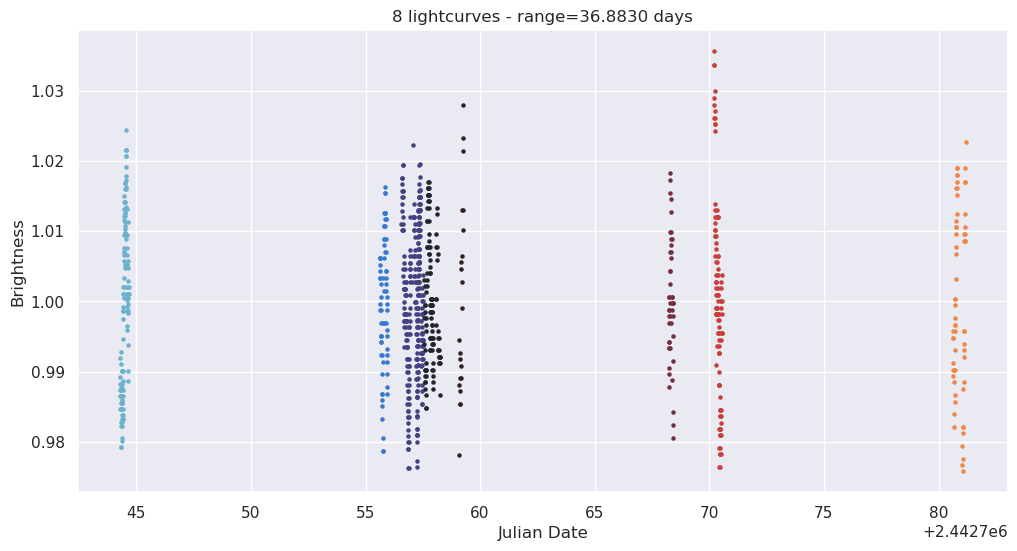

2024-06-27 22:50:06,766 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=8 with total points=874


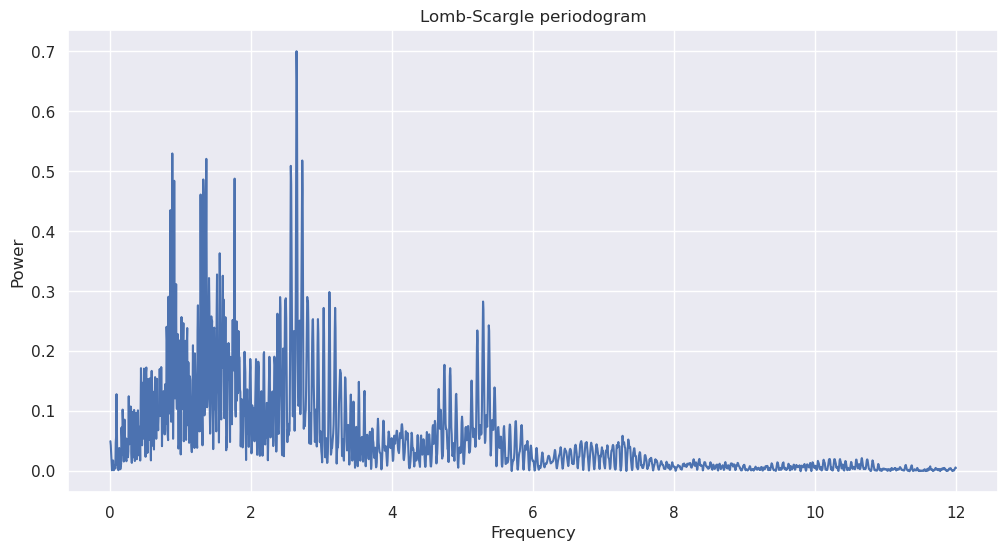

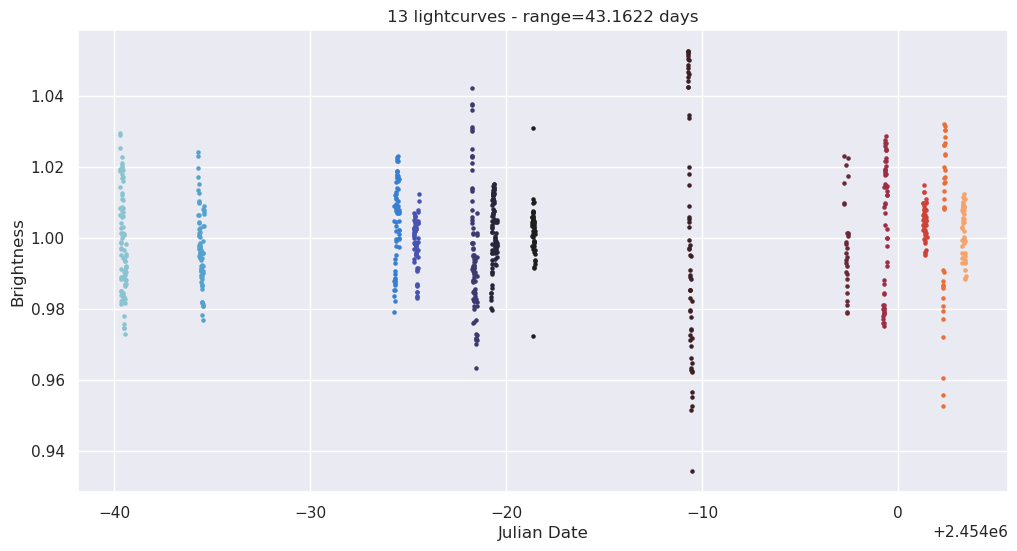

2024-06-27 22:50:08,194 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=13 with total points=798


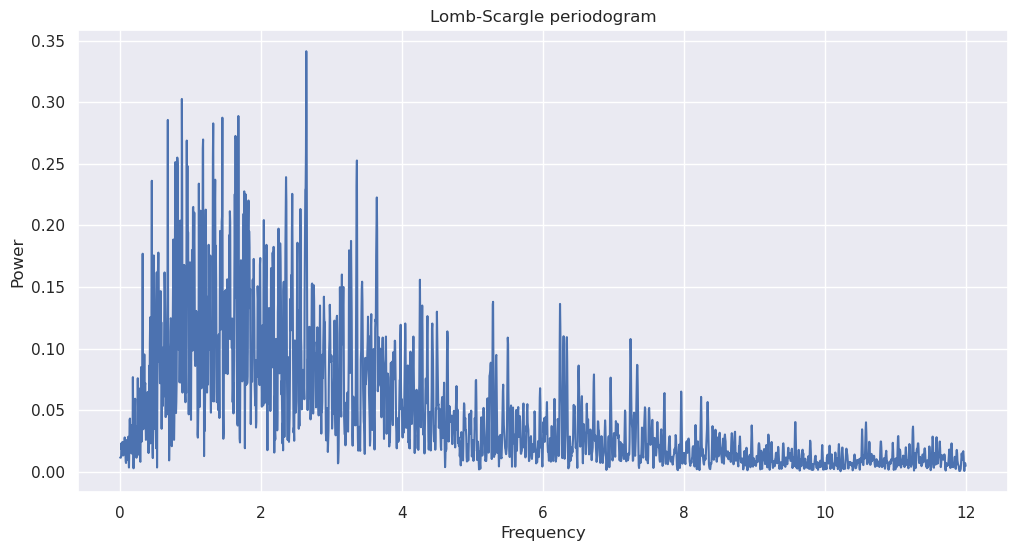

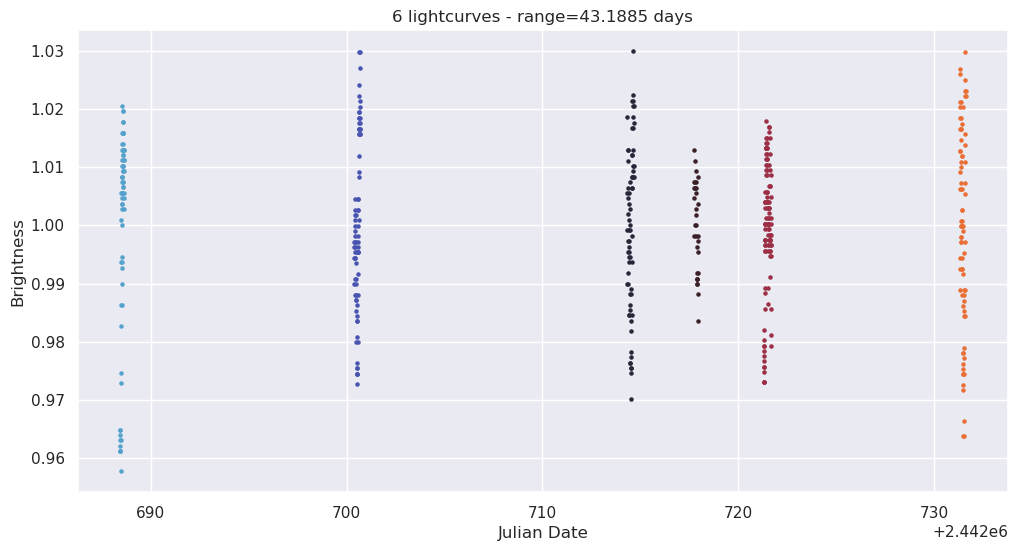

2024-06-27 22:50:09,819 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=6 with total points=451


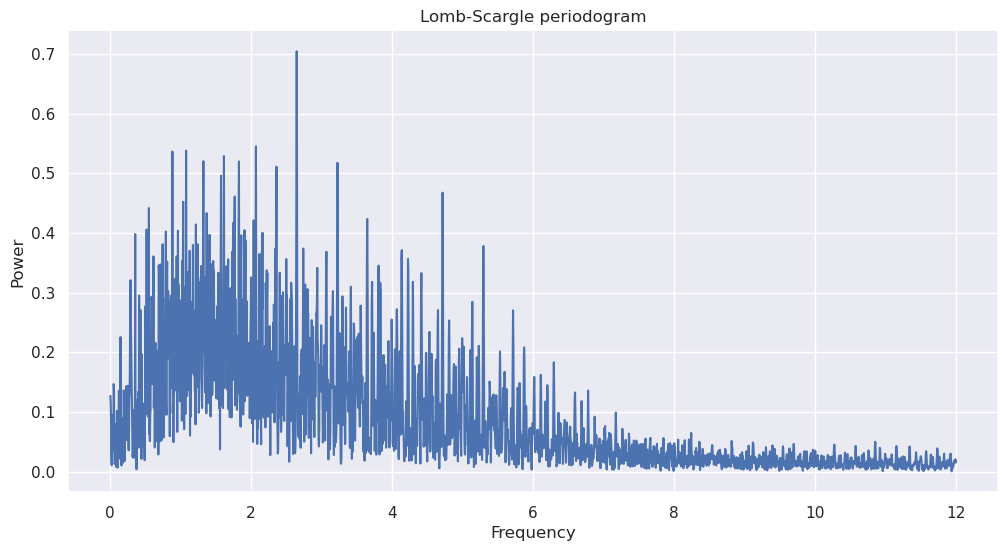

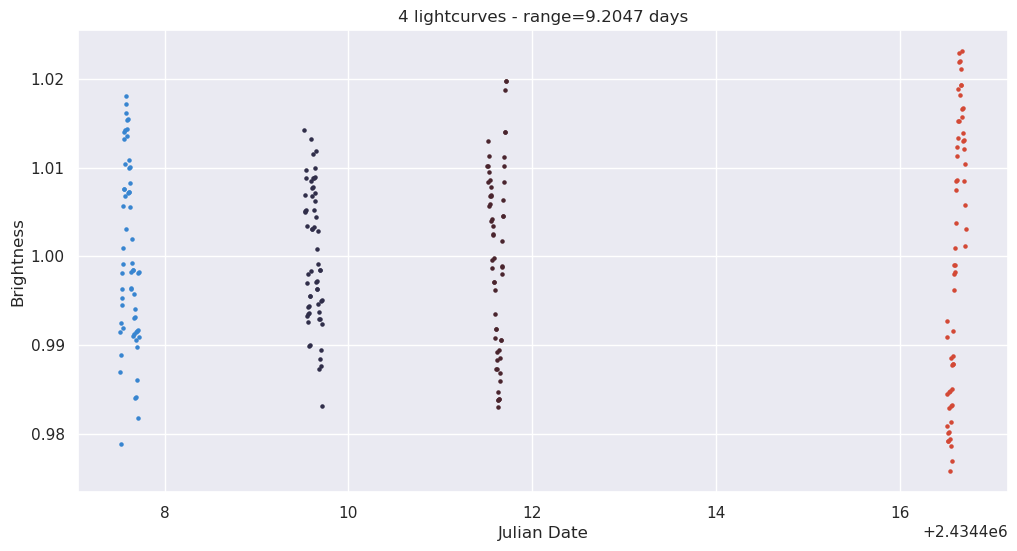

2024-06-27 22:50:10,803 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=4 with total points=241


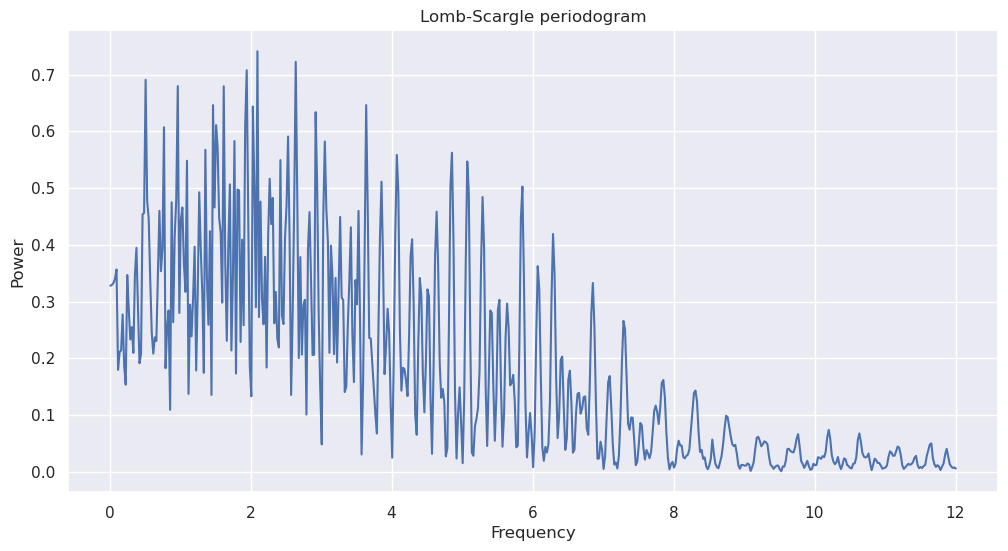

--------------------------------------------------



(array([[2.64349737, 2.64891993, 0.88116579, 1.36377352, 2.72483576,
         2.56215899, 2.63807482, 1.76504286, 1.32039305, 0.90827859,
         2.56758155, 2.73025831, 1.32581561, 1.28243514, 0.854053  ,
         2.7194132 , 2.65434249, 1.35835096, 2.55673644, 1.55356307,
         2.57300411, 1.7596203 , 1.51560516, 1.59694354, 1.40173143,
         2.71399064, 0.93539138, 1.2878577 , 3.10983742, 0.8269402 ,
         2.79532902, 2.41032735, 1.36919608, 2.63265226, 2.49166573,
         1.60778866, 2.48624317, 2.48082061, 2.80075158, 2.80617414,
         5.28970603, 1.55898563, 2.73568087, 1.27701258, 1.24447723,
         1.40715399, 3.19117581, 3.02849904, 2.41574991, 3.11525998],
        [2.64351935, 0.87808399, 1.67971212, 1.45266138, 0.67883538,
         2.64815304, 1.3229181 , 1.63800892, 1.64264261, 1.17927375,
         0.94758932, 1.17464006, 2.63888566, 0.81321235, 1.31828441,
         3.36174109, 0.78541022, 0.81784604, 0.9568567 , 2.35623066,
         1.35072023, 0.45178464, 

In [16]:
get_freq_features(asteroid, config, debug=True)

In [17]:
config['max_debug'] = False

In [18]:
assert not config["max_debug"], "Disable max_debug before running for all asteroids!!!"

failed_cnt = 0
asteroids_data = {}
for asteroid_name, asteroid in tqdm(asteroids.items()):
    start = perf_counter()
    features = get_freq_features(asteroid, config, as_list=True, debug=False)
    processing_time = perf_counter() - start

    asteroids_data[asteroid_name] = {
        "is_failed": False,
        "reason": None,
        "period": asteroid.period,
        "processing_time": processing_time,
        "freq_features": [],
        "pow_features": [],
    }
    if isinstance(features, dict):
        failed_cnt += 1
        asteroids_data[asteroid_name]["is_failed"] = True
        asteroids_data[asteroid_name]["reason"] = features["reason"]
        continue

    freq_features, pow_features = features

    asteroids_data[asteroid_name]["freq_features"] = freq_features
    asteroids_data[asteroid_name]["pow_features"] = pow_features

print(f"Failed asteroids: {failed_cnt} ({failed_cnt / len(asteroids) * 100:.2f}%)")
print(f"{'-'*50}")

dump_data = {
    "config": config,
    "asteroids": asteroids_data,
}

with open(ASTEROIDS_FREQ_DATA_PATH, "w") as f:
    json.dump(dump_data, f, indent=4)

100%|██████████| 4467/4467 [08:50<00:00,  8.42it/s]  


Failed asteroids: 2648 (59.28%)
--------------------------------------------------


In [19]:
failed_asteroids = filter(lambda x: x[1]["is_failed"], asteroids_data.items())


In [25]:
from collections import Counter

In [26]:
reasons = Counter([failed_asteroid["reason"] for _, failed_asteroid in failed_asteroids])
print(reasons)

Counter({'no bins': 2581, 'anomalous series': 65})
